# Homework Assignment #5. RNA Folding

Implement Nussinov algorithm for RNA folding.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Nussinov algorithm

In [2]:
def traceback(m, trace, i, j, pin):
    """
    Traceback from scores of Nussinov matrix and traceback matrix.
    Args:
        m (np.ndarray): score matrix
        trace (np.ndarray): trace matrix
        i: row index of trace
        j: column index of trace
    Return (list): list of connected string indices
    """
    trace_path = []
    split_encountered = False
    while i <= j and not split_encountered:
        if trace[i, j] == 0:
            trace_path.append([i])
            i += 1
        elif trace[i, j] == 1:
            trace_path.append([j])
            j -= 1
        elif trace[i, j] == 2:
            trace_path.append([i, j])
            i += 1; j -= 1
        else:
            for k in range(i, j-pin):
                if m[i, j] == m[i, k] + m[k+1, j]:
                    trace_path += traceback(m, trace, i, k, pin)
                    trace_path += traceback(m, trace, k+1, j, pin)
                    split_encountered = True
                    break
    return trace_path


def calc_nussinov_pairs(s, pin=3):
    """
    Calculates all connected pairs in folded RNA.
    Args:
        s (str): RNA string
        pin (int): min RNA pin limit
    Return:
        (list): list of list of either [i, j] (connected) or [i] (disconnected) indices of string.
    """
    n = len(s)
    m = np.zeros((n, n))
    trace = np.zeros((n, n)) # 0 - upward, 1 - leftward, 2 - equal, 3 - jump

    def is_compl(i, j):
        return (s[i], s[j]) in [('A', 'U'), ('U', 'A'), ('G', 'C'), ('C', 'G')]

    for k in range(pin+1, n):
        for i in range(n-k):
            j = i + k
            m[i, j] = max(
                m[i+1, j], 
                m[i, j-1],
                max([m[i, k] + m[k+1, j] for k in range(i, j-1)] + [-np.inf])
            )
            if is_compl(i, j):
                m[i, j] = max(m[i, j], m[i+1, j-1]+1)

            # Fill trace matrix
            if m[i, j] == m[i+1, j]:
                trace[i, j] = 0
            elif m[i, j] == m[i, j-1]:
                trace[i, j] = 1
            elif m[i, j] == m[i+1, j-1] + is_compl(i, j):
                trace[i, j] = 2
            else:
                trace[i, j] = 3
                
    trace_path = traceback(m, trace, i=0, j=len(s)-1, pin=pin)
    return trace_path

### Utils

In [3]:
def make_table(trace_path, s):    
    c1, c2, i1, i2 = [], [], [], []
    for pair in trace_path:
        if len(pair) == 1:
            c1.append(s[pair[0]])
            c2.append('-')
            i1.append(int(pair[0]))
            i2.append('-')
        else:
            c1.append(s[pair[0]])
            c2.append(s[pair[1]])
            i1.append(int(pair[0]))
            i2.append(int(pair[1]))
    return pd.DataFrame({'index1': i1, 'index2': i2, 'sym1': c1, 'sym2': c2})
            
            
def num_nuc_pairs(trace_pairs):
    return sum([len(p) == 2 for p in trace_pairs])


def plot_rna_cirle(pairs, rna_len, figsize=(10, 10)):

    def get_coords(ind_1, ind_2, max_ind):
        step = (2 * np.pi / max_ind)
        r = 0.5
        phi1 = ind_1 * step
        x1 = r * np.cos(phi1)
        y1 = r * np.sin(phi1)
        phi2 = ind_2 * step
        x2 = r * np.cos(phi2)
        y2 = r * np.sin(phi2)
        return [0.5 + x1, 0.5 + x2], [0.5 + y1, 0.5 + y2]

    # Calculate decard coorindates from pair of indices == pair of angles
    coords = []
    for pair in pairs:
        if len(pair) == 2:
            coords += get_coords(pair[0], pair[1], rna_len)

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    circle = plt.Circle((0.5, 0.5), 0.5, color='k', lw=1, ls='-', fill=False)
    plt.plot(*coords)
    ax.add_artist(circle)
    ax.axis('off')

    plt.show()

### Test 1

* Test string: GGACC  
* Expected nuc pairs: 1

In [4]:
s = 'GGACC'
pairs = calc_nussinov_pairs(s)
make_table(pairs, s)

,index1,index2,sym1,sym2
0,0,4,G,C
1,1,-,G,-
2,2,-,A,-
3,3,-,C,-


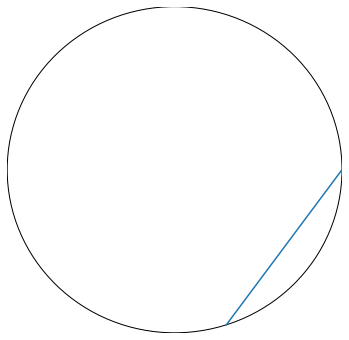

In [5]:
plot_rna_cirle(pairs, len(s), figsize=(6, 6))

### Test 2

* Test string: AAACAUGAGGAUUACCCAUGU
* Expected nuc pairs: 7

In [6]:
s = 'AAACAUGAGGAUUACCCAUGU'
pairs = calc_nussinov_pairs(s)
print("Pairs: ", num_nuc_pairs(pairs))
make_table(pairs, s)

Pairs:  7


,index1,index2,sym1,sym2
0,0,-,A,-
1,1,-,A,-
2,2,20,A,U
3,3,19,C,G
4,4,18,A,U
5,5,17,U,A
6,6,16,G,C
7,7,-,A,-
8,8,15,G,C
9,9,14,G,C


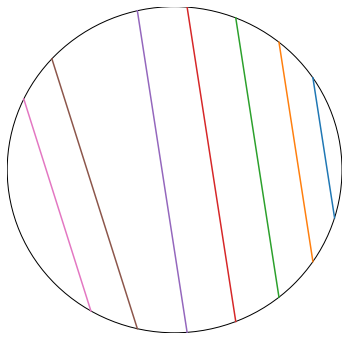

In [7]:
plot_rna_cirle(pairs, len(s), figsize=(6, 6))

### Additional test with bigger RNA

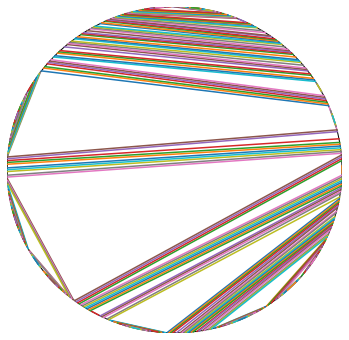

In [8]:
def dna2rna(s):
    d = {'a': 'A', 'c': 'C', 't': 'U', 'g': 'G', '\n': ''}
    return ''.join(list(map(lambda x: d[x], s.strip())))
        
    
dna = '''
agcttttcattctgactgcaacgggcaatatgtctctgtgtggattaaaaaaagagtctctgacagcagcttctgaactg
gttacctgccgtgagtaaattaaaattttattgacttaggtcactaaatactttaaccaatataggcatagcgcacagac
agataaaaattacagagtacacaacatccatgaaacgcattagcaccaccattaccaccaccatcaccaccaccatcacc
attaccattaccacaggtaacggtgcgggctgacgcgtacaggaaacacagaaaaaagcccgcacctgacagtgcgggct
tttttttcgaccaaaggtaacgaggtaacaaccatgcgagtgttgaagttcggcggtacatcagtggcaaatgcagaacg
ttttctgcgggttgccgatattctggaaagcaatgccaggcaggggcaggtggccaccgtcctctctgcccccgccaaaa
tcaccaaccacctggtggcgatgattgaaaaaaccattagcggccaggatgctttacccaatatcagcgatgccgaacgt
'''

rna = dna2rna(dna)
pairs = calc_nussinov_pairs(rna)

plot_rna_cirle(pairs, len(rna), figsize=(6, 6))

### Inference

The difference between paired nucleotides is at least 3 as requirement agreed, visual diagrams show that no connections are overlapped